<a href="https://colab.research.google.com/github/Ermiyas21/ICSSWaT/blob/main/swat_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports the required packages 

from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import io
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
from sklearn.mixture import GaussianMixture
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     
from sklearn import mixture
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier 
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectPercentile

In [ ]:
# mount the data from google drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Reading

In [ ]:
#Data description - classfiying the coloumns in to sessor and actuator 
sensor_columns = ['FIT101','LIT101','AIT201','AIT202','AIT203','FIT201','DPIT301','FIT301','LIT301','AIT401','AIT402','FIT401','LIT401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504','PIT501','PIT502','PIT503','FIT601']
actuator_columns = ['MV101','P101','P102', 'MV201', 'P201', 'P202','P203', 'P204','P205','P206','MV301','MV302','MV303','MV304','P301','P302','P401','P402','P403','P404','UV401','P501','P502','P601','P602','P603']
timestamp_col = 'Timestamp' 
label_col = 'Normal/Attack'
#Data Reading
df = pd.read_csv('/content/gdrive/My Drive/LAB1 PROJECT/SWaT_Dataset_Attack_v0 (1).csv', parse_dates = [' Timestamp'], index_col = ' Timestamp')
#Strip whitespaces
df = df.rename(columns=lambda x: x.strip())

#Data Cleanup
df = df.dropna()

# Preprocessing

In [ ]:
# preprocessoing the data with onehot encoding for catagorical data and Normalize numrical data with min max scaler 
def preprocess(df):
  df = df.copy()
  #OneHotEncode categorical data
  encoder = OneHotEncoder(sparse = False)
  enc_df = pd.DataFrame(encoder.fit_transform(df[actuator_columns]))
  enc_df.index = df.index
  df.drop(actuator_columns, axis='columns', inplace=True)
  
  #Normalize numerical data
  minmax_scale = pd.DataFrame(MinMaxScaler().fit_transform(df[sensor_columns]))
  minmax_scale.index = df.index 

  df.drop(sensor_columns, axis='columns', inplace=True)

  #LabelEncode y - Class 
  label_enc = pd.DataFrame(LabelEncoder().fit_transform(df[label_col]))
  label_enc.index = df.index
  df.drop([label_col], axis='columns', inplace=True)
  #concat retval - concatenate all encode data to variable ret 
  ret = pd.DataFrame()
  retVal = pd.concat([df, enc_df, minmax_scale, label_enc], axis=1, ignore_index=True)
  retVal = retVal.reindex(df.index)
  return retVal

processed_df = preprocess(df)
processed_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.879322,0.452962,0.942783,0.876785,0.436773,0.865044,0.438853,0.928726,0.707350,0.500000,0.079038,0.982007,0.920088,0.509897,0.106829,0.375534,0.005773,0.982970,0.940678,0.991540,0.987464,0.985802,0.837398,0.987359,0.000071,2
2015-12-28 10:00:01,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.886285,0.453015,0.942783,0.876785,0.436773,0.865044,0.438853,0.929319,0.707350,0.500000,0.079038,0.983402,0.920037,0.509897,0.106829,0.375534,0.005773,0.982970,0.953861,0.991540,0.987464,0.985802,0.837398,0.987783,0.000071,2
2015-12-28 10:00:02,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.901833,0.452962,0.942783,0.876081,0.436773,0.863956,0.437572,0.929480,0.707733,0.500000,0.079038,0.983402,0.919834,0.509897,0.106829,0.375534,0.005773,0.982751,0.951224,0.991540,0.990135,0.985868,0.837398,0.987783,0.000071,2
2015-12-28 10:00:03,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.918195,0.453122,0.942783,0.876081,0.436773,0.863956,0.437572,0.929480,0.708116,0.500000,0.079038,0.982667,0.919733,0.509897,0.106112,0.375534,0.005773,0.982751,0.941808,0.991540,0.990135,0.985868,0.837398,0.987444,0.000071,2
2015-12-28 10:00:04,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.930842,0.453816,0.942783,0.876081,0.436773,0.864228,0.437572,0.929480,0.708451,0.500000,0.079038,0.982667,0.920290,0.509897,0.105216,0.375534,0.005773,0.982751,0.941808,0.991540,0.990135,0.985868,0.837398,0.986850,0.000071,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-01 14:59:55,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.927477,0.448477,0.000643,0.965415,0.167313,0.870030,0.453294,0.924412,0.729325,0.450104,0.024708,0.977306,0.939572,0.357771,0.064886,0.233640,0.012168,0.978804,0.947551,0.991022,0.983559,0.986980,0.439024,0.984305,0.000000,2
2016-02-01 14:59:56,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.923532,0.449652,0.000643,0.965415,0.167313,0.870030,0.453294,0.924412,0.729373,0.450104,0.024708,0.977306,0.939977,0.357771,0.064886,0.233640,0.012168,0.977708,0.935593,0.991022,0.983559,0.986653,0.439024,0.983796,0.000000,2
2016-02-01 14:59:57,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.

# Feature Selection

In [ ]:
#binarize label
processed_df[76][processed_df[76] == 2] = 0
#Discrete features are from [0-50]
discrete_feat_idx = range(0, 51)

#Use mutual info to feature select 10% of the columns and transform the train and test sets accordingly
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)
fs = SelectPercentile(score_func)

# classfifying the data train and test 
X_train, X_test, y_train, y_test = train_test_split(processed_df.drop([76],axis=1), processed_df[76] , test_size=0.2, random_state=0)
fs.fit(X_train, y_train)

# after feature selection 
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# GMM

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and 

Text(0.5, 1.0, 'Predicted probabilities for test dataset')

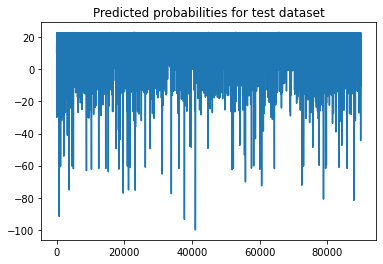

In [ ]:
#Hyperparamters
param_grid = {'n_components': [2, 5, 6], 
              'n_init': [1, 2]} 

grid = GridSearchCV(GaussianMixture(), param_grid, refit = True, scoring='recall_macro') 

# fitting the model for grid search
grid.fit(X_train_fs, y_train)
#Plot predictid probabilities to optimize threshold
y_test_proba = grid.best_estimator_.score_samples(np.vstack([X_test_fs]))
plt.plot(y_test_proba)
plt.title('Predicted probabilities for test dataset')

Classification report
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     79171
           1       0.57      0.05      0.09     10813

    accuracy                           0.88     89984
   macro avg       0.73      0.52      0.51     89984
weighted avg       0.85      0.88      0.83     89984

Confusion matrix
[[78783   388]
 [10289   524]]
Test AUCPR = 0.14218590273572673


Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.14')

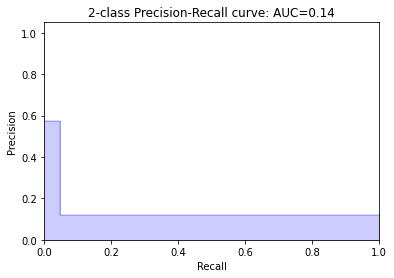

In [ ]:
#Optimize threshold for best AUC score
y_test_proba = grid.best_estimator_.score_samples(X_test_fs)
plt.plot(y_test_proba)
plt.title('Predicted probabilities for test dataset')
best_auc = 0.0
best_tresh = -1
for i in range (-100, 0):
  y_test_proba = grid.best_estimator_.score_samples(X_test_fs)
  T=i
  y_test_proba[y_test_proba>=T]=0
  y_test_proba[y_test_proba<T]=1
  y_test_orig=y_test
  y_test_orig = [x if x == 1 else 0 for x in y_test_orig]
  curr_auc = average_precision_score(y_test_orig, y_test_proba)
  if (curr_auc > best_auc):
    best_auc = curr_auc
    best_tresh = i
#Recalculate with the found best threshold
y_test_orig=y_test
y_test_proba = grid.best_estimator_.score_samples(X_test_fs)
plt.plot(y_test_proba)
plt.title('Predicted probabilities for test dataset')
T=best_tresh
y_test_proba[y_test_proba>=T]=0
y_test_proba[y_test_proba<T]=1


y_test_orig=np.hstack([y_test])
y_test_orig = [x if x == 1 else 0 for x in y_test_orig]

print('Classification report')
print(classification_report(y_test_orig, y_test_proba))
print('Confusion matrix')
cf_matrix = confusion_matrix(y_test_orig, y_test_proba)
print(cf_matrix)
print('Test AUCPR = ' + str(average_precision_score(y_test_orig, y_test_proba)))



precision, recall, _ = precision_recall_curve(y_test_orig, y_test_proba)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test_orig, y_test_proba)))


Classification report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     39534
           1       1.00      0.62      0.77     27292

    accuracy                           0.85     66826
   macro avg       0.90      0.81      0.83     66826
weighted avg       0.88      0.85      0.84     66826

Confusion matrix
[[39484    50]
 [10302 16990]]
Test AUCPR = 0.7748616386588567


Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.77')

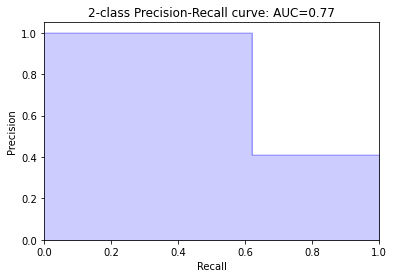

In [ ]:
# another GMM 
df_0=processed_df[processed_df[76]==0]    #Dataset with non-attack only
df_1=processed_df[processed_df[76]==1]    #Dataset with attack only


#Split non-attack data in 90% for training GMM and 10% for cross-validation and testing
X_train, X_test, y_train, y_test = train_test_split(df_0.drop([76],axis=1), df_0[76] , test_size=0.1, random_state=0)
#Split the attack data in 50% for cross-validation and 50% for testing
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1.drop([76],axis=1), df_1[76] , test_size=0.5, random_state=0)
#Feature scale data
X_train_gmm_fs = fs.transform(X_train)
X_test_gmm_fs = fs.transform(X_test)

X_train_gmm_1_fs = fs.transform(X_train_1)
X_test_gmm_1_fs = fs.transform(X_test_1)

# Fit a Gaussian Mixture Model 
clf = mixture.GaussianMixture()
clf.fit(X_train_gmm_fs)

y_test_proba = clf.score_samples(np.vstack([X_test_gmm_fs, X_test_gmm_1_fs]))
plt.plot(y_test_proba)
plt.title('Predicted probabilities for test dataset')

#Calculate best threshold -> find best auc score
best_auc = 0
best_tresh = -1

for i in range (-1000, 0):
  y_test_proba = clf.score_samples(np.vstack([X_test_gmm_fs, X_test_gmm_1_fs]))
  T=i
  y_test_proba[y_test_proba>=T]=0
  y_test_proba[y_test_proba<T]=1
  y_test_orig=np.hstack([y_test, y_test_1])
  y_test_orig = [x if x == 1 else 0 for x in y_test_orig]
  curr_auc = average_precision_score(y_test_orig, y_test_proba)
  if (curr_auc > best_auc):
    best_auc = curr_auc
    best_tresh = i

#Recalculate with the found best threshold
y_test_proba = clf.score_samples(np.vstack([X_test_gmm_fs, X_test_gmm_1_fs]))
T=best_tresh
y_test_proba[y_test_proba>=T]=0
y_test_proba[y_test_proba<T]=1

y_test_orig=np.hstack([y_test, y_test_1])
y_test_orig = [x if x == 1 else 0 for x in y_test_orig]

print('Classification report')
print(classification_report(y_test_orig, y_test_proba))
print('Confusion matrix')
cf_matrix = confusion_matrix(y_test_orig, y_test_proba)
print(cf_matrix)
print('Test AUCPR = ' + str(average_precision_score(y_test_orig, y_test_proba)))



precision, recall, _ = precision_recall_curve(y_test_orig, y_test_proba)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test_orig, y_test_proba)))



# OCSVM

In [ ]:
#Hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 
              'penalty': ['l1', 'l2']} 
  
grid = GridSearchCV(LinearSVC(), param_grid, refit = True)
  
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)
yhat=grid.predict(X_test)


print('Classification report')
print(classification_report(y_test, yhat))
print('Confusion matrix')
cf_matrix = confusion_matrix(y_test, yhat)
print(cf_matrix)
print('Test AUCPR = ' + str(average_precision_score(y_test, yhat)))



precision, recall, _ = precision_recall_curve(y_test, yhat)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test, yhat)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contain

ValueError: ignored

# *Index*-based KNN

In [ ]:
#weight based on average of k nearest neighbors
def weight_fn(distances):
    weights = np.array(np.full(distances.shape, 0), dtype='float')
    for i in range(distances.shape[0]): # for each prediction:
        avg = 0.0
        for j in range(distances.shape[1]):
          avg = avg + distances[i,j]
        avg = avg / distances.shape[1]
        for j in range(distances.shape[1]):
          weights[i, j] = avg

    return weights

In [ ]:
#n_neighbors=55 seems to not over or underfit, smaller values produced a heavily overfitted model
neigh = KNeighborsClassifier(n_neighbors=55, weights=weight_fn, algorithm='kd_tree')
neigh.fit(X_train_fs, y_train)

yhat=neigh.predict(X_test_fs)


print('Classification report')
print(classification_report(y_test, yhat))
print('Confusion matrix')
cf_matrix = confusion_matrix(y_test, yhat)
print(cf_matrix)
print('Test AUCPR = ' + str(average_precision_score(y_test, yhat)))



precision, recall, _ = precision_recall_curve(y_test, yhat)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test, yhat)))

ValueError: ignored

# Brute-force KNN

In [ ]:

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split


neigh = KNeighborsClassifier(n_neighbors=55, algorithm='brute')
neigh.fit(X_train_fs, y_train)

yhat=neigh.predict(X_test_fs)


print('Classification report')
print(classification_report(y_test, yhat))
print('Confusion matrix')
cf_matrix = confusion_matrix(y_test, yhat)
print(cf_matrix)
print('Test AUCPR = ' + str(average_precision_score(y_test, yhat)))



precision, recall, _ = precision_recall_curve(y_test, yhat)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test, yhat)))



ValueError: ignored

# DBSCAN


In [ ]:
# data wrangling
import pandas as pd
# visualization
import matplotlib.pyplot as plt
# algorithm
from sklearn.cluster import DBSCAN

In [ ]:
X=processed_df.drop([76],axis=1)
Y=processed_df[76]



In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.879322,0.452962,0.942783,0.876785,0.436773,0.865044,0.438853,0.928726,0.707350,0.500000,0.079038,0.982007,0.920088,0.509897,0.106829,0.375534,0.005773,0.982970,0.940678,0.991540,0.987464,0.985802,0.837398,0.987359,0.000071
2015-12-28 10:00:01,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.886285,0.453015,0.942783,0.876785,0.436773,0.865044,0.438853,0.929319,0.707350,0.500000,0.079038,0.983402,0.920037,0.509897,0.106829,0.375534,0.005773,0.982970,0.953861,0.991540,0.987464,0.985802,0.837398,0.987783,0.000071
2015-12-28 10:00:02,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.901833,0.452962,0.942783,0.876081,0.436773,0.863956,0.437572,0.929480,0.707733,0.500000,0.079038,0.983402,0.919834,0.509897,0.106829,0.375534,0.005773,0.982751,0.951224,0.991540,0.990135,0.985868,0.837398,0.987783,0.000071
2015-12-28 10:00:03,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.918195,0.453122,0.942783,0.876081,0.436773,0.863956,0.437572,0.929480,0.708116,0.500000,0.079038,0.982667,0.919733,0.509897,0.106112,0.375534,0.005773,0.982751,0.941808,0.991540,0.990135,0.985868,0.837398,0.987444,0.000071
2015-12-28 10:00:04,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.930842,0.453816,0.942783,0.876081,0.436773,0.864228,0.437572,0.929480,0.708451,0.500000,0.079038,0.982667,0.920290,0.509897,0.105216,0.375534,0.005773,0.982751,0.941808,0.991540,0.990135,0.985868,0.837398,0.986850,0.000071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-01 14:59:55,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.927477,0.448477,0.000643,0.965415,0.167313,0.870030,0.453294,0.924412,0.729325,0.450104,0.024708,0.977306,0.939572,0.357771,0.064886,0.233640,0.012168,0.978804,0.947551,0.991022,0.983559,0.986980,0.439024,0.984305,0.000000
2016-02-01 14:59:56,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.923532,0.449652,0.000643,0.965415,0.167313,0.870030,0.453294,0.924412,0.729373,0.450104,0.024708,0.977306,0.939977,0.357771,0.064886,0.233640,0.012168,0.977708,0.935593,0.991022,0.983559,0.986653,0.439024,0.983796,0.000000
2016-02-01 14:59:57,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.917150,0.450026,0.

In [ ]:
# Hyper parameter optimization for dbscan


We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.


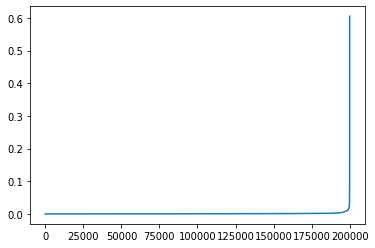

In [ ]:
from sklearn.neighbors import NearestNeighbors

sample = processed_df.sample(n=200000)
X = fs.transform(sample.drop([76],axis=1))
Y = sample[76] 

neigh = NearestNeighbors(n_neighbors=11)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=0.02, min_samples=5).fit(X) 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.12')

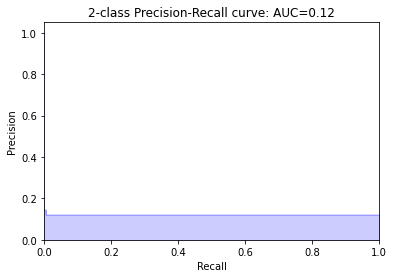

In [ ]:
outliers = X[db.labels_ == -1]
yhat = [0 if x != -1 else 1 for x in db.labels_]
y_test = Y.values
print(yhat)
print('Classification report')
print(classification_report(y_test, yhat))
print('Confusion matrix')
cf_matrix = confusion_matrix(y_test, yhat)
print(cf_matrix)
print('Test AUCPR = ' + str(average_precision_score(y_test, yhat)))



precision, recall, _ = precision_recall_curve(y_test, yhat)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test, yhat)))